# Leakage - Gadolinium DCE

Use this notebook for single animals, otherwise run it in batch from **GLUT1_Analysis**

In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import MRIhelperfunctions as h
import MRIhelperfunctions
from MRIhelperfunctions import Settings
from imp import importlib
import fnmatch
import papermill as pm

import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline  

In [23]:
importlib.reload(h)
import MRIhelperfunctions as h
from MRIhelperfunctions import Settings

In [2]:
# Default Parameters (to run script independently)
folders = {}
folders['raw'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata'
folders['main'] = os.path.dirname(folders['raw'])
folders['analysis'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Analysis'
folders['animal'] = '/home/aic/BigHDD/MR_DATA/GLUT1/Rawdata/20180604_101508_Glut1_2_2'
folders['excel'] = 'Animal_Scan_IDs.xlsx'


animal = 'glut1_male1'


info = h.getinfo(folders)
info

In [13]:
# additional Script specific parameters

# info = pd.read_json(info)  #<-- dont run this line in single animal mode

folders['template'] = os.path.join(folders['main'], 'Templates', 'Leakage_gd.nii' ) # from animal glut1_male1
folders['in'] = os.path.join(folders['analysis'], animal)
folders['out'] = os.path.join(folders['in'], 'Leakage')

In [10]:
scans={}
scans['number'] = int(info.loc['Gd DCE', animal])

scans['raw'] = os.path.join(folders['in'], f"X{scans['number']}P1.nii")


raw = nib.load(scans['raw'])
print(f'check if these dimensions make sense:  pre: {raw.shape}')

check if these dimensions make sense:  pre: (80, 80, 300)


In [60]:
# coregistration

scans['single'] = f"{folders['out']}/single_timepoint.nii"

# get single repetition
h.runAFNI(f"3dTcat -prefix {scans['single']} {scans['raw']}'[0]'")

scans['single_coreg'], scans['coreg'] = h.simple_coreg(folders['template'], scans['single'], scans['raw'], folders['out'])

3dTcat -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Leakage/single_timepoint.nii /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/X6P1.nii'[0]'
3dAllineate -base /home/aic/BigHDD/MR_DATA/GLUT1/Templates/Leakage_gd.nii -source /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Leakage/single_timepoint.nii -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Leakage/A_coreg.nii -cost ls -zclip -interp quintic -final wsinc5 -twopass -twoblur 2 -fineblur 0.5 -nmatch 80% -conv 0.01 -1Dparam_save /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Leakage/1dparams.1D
3dAllineate -1Dparam_apply /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Leakage/1dparams.1D -source /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/X6P1.nii -prefix /home/aic/BigHDD/MR_DATA/GLUT1/Analysis/glut1_male1/Leakage/B_coreg.nii -cost ls -zclip -interp quintic -final wsinc5 -twopass -twoblur 2 -fineblur 0.5 -nmatch 80% -conv 0.01 -master /home/aic/BigHDD/MR_DATA/GLUT1/Templates/Leakag

In [115]:
img = nib.load(scans['coreg'])
data = img.get_fdata()
hdr = img.header
print(hdr)

dimensions = Settings()
# dimensions.res = [hdr['pixdim'][1], hdr['pixdim'][2], hdr['pixdim'][3]]
# dimensions.fov = [ dimensions.res[0]*(hdr['dim'][1]-1), dimensions.res[1]*(hdr['dim'][2]-1), dimensions.res[2]*(hdr['dim'][3]-1) ]
# dimensions.min = [ -hdr['qoffset_x'], -hdr['qoffset_y'], hdr['qoffset_z']-dimensions.fov[2] ]
# dimensions.max = [ -hdr['qoffset_x']+dimensions.fov[0], -hdr['qoffset_y']+dimensions.fov[1], float(hdr['qoffset_z'])]
dimensions.time = hdr['pixdim'][3] # normally Z, here its time

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3  80  80 300   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.   0.25 0.25 2.   0.   0.   0.   0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : -0.70710677
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -9.721977
qoffset_y       : -299.78116
qoffset_z       : 6.2221427
srow_x     

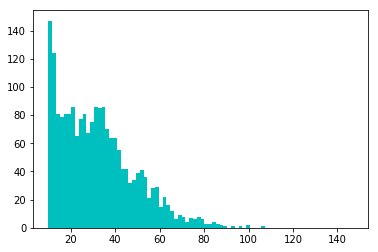

In [42]:
data_averaged = np.mean(data,axis=2)  # average time points

threshold = 10
# data[data <= threshold] = 0

plt.hist(data_averaged.flatten(), bins=80, color='c', range=(threshold, np.max(data)))
plt.show()

In [57]:
threshold=35

for columns in data:
    for voxel in columns:
        if np.mean(voxel) > threshold:
            x=voxel

In [105]:
# mean pre-injection
cutoff = 2 #initial cutoff and some safety margin before dip
bsl_end = 45

mean_pre = np.mean(x[cutoff:bsl_end]) 

# start searching from the minimum
min_point = np.argmin(x)
max_point = np.argmax(x)
max_val = np.max(x)

x0 = np.argmax(x[min_point:] >= mean_pre) + min_point

xend = int(np.argwhere(x[max_point:]<0.95*max_val)[0]) + max_point #first point where it drops below 95% of max

In [106]:
xend

172

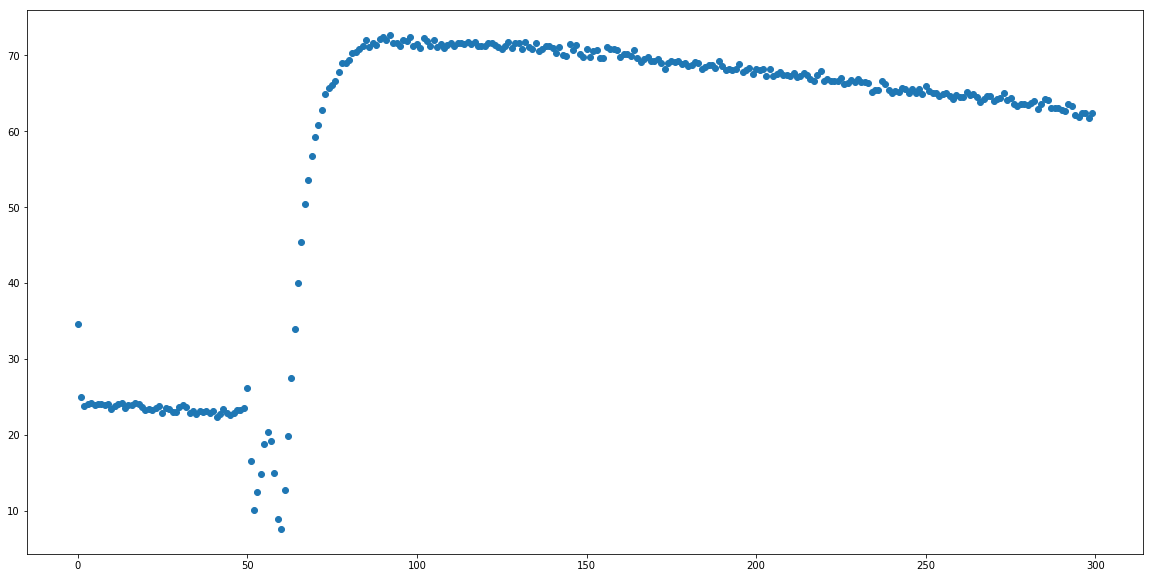

In [93]:
plt.figure(figsize=(20,10))
plt.plot(x[0:],'o')

In [118]:
time.size

55

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 109
    # variables        = 2
    chi-square         = 4032.88725
    reduced chi-square = 37.6905351
    Akaike info crit   = 397.587005
    Bayesian info crit = 402.969701
[[Variables]]
    B:       41.5621434 (init = 1)
    ktrans:  35.5183529 (init = 0.2)



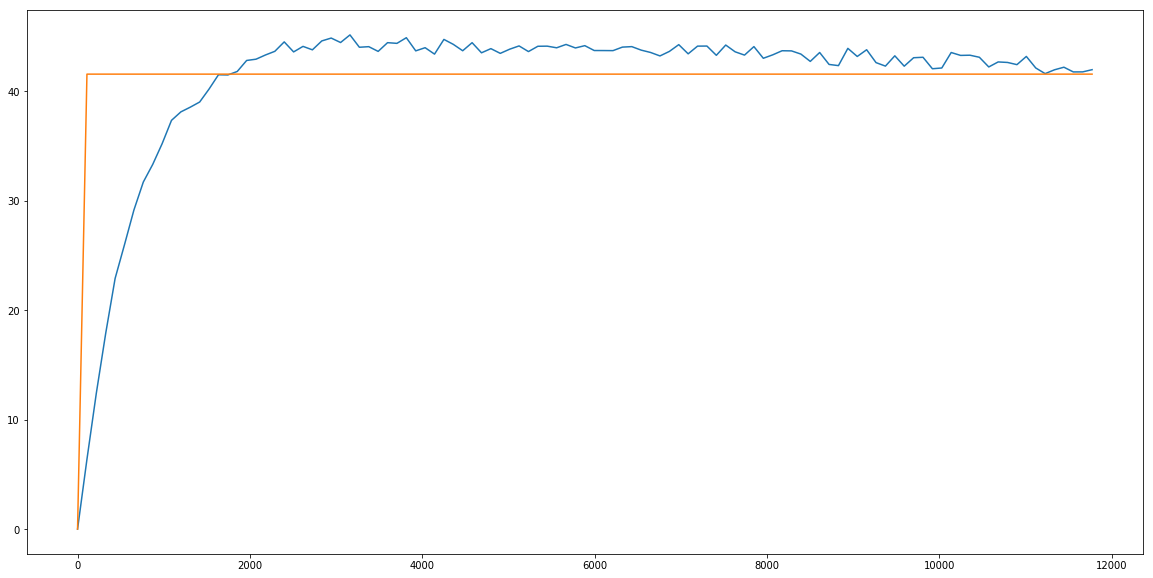

In [133]:
from lmfit.models import ExpressionModel

model = ExpressionModel('B*(1 - exp(-ktrans * (x)))')
params = model.make_params()

params = model.make_params()
# params['A'].set(value=1, min=0.01, max=5)
params['ktrans'].set(value=0.2, min=0.01, max=100)
params['B'].set(value=1, min=0.01, max=100)



signal = x[x0:xend]-x[x0]

time = np.arange(0, signal.size, 1)*signal.size

result = model.fit(signal, params, x=time)

# mod = ExpressionModel('off + amp * exp(-x/x0) * sin(x*phase)')

print(result.fit_report())
plt.figure(figsize=[20,10])
plt.plot(time, signal)
plt.plot(time, result.best_fit)

In [66]:
1 - np.exp(-0.5 * 0)

0.0